<a href="https://colab.research.google.com/github/hanumantjain/PyTorch/blob/main/ImageClassificationPretrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Classification on Pre-trained Model


In [1]:
!pip install opendatasets --quiet
import opendatasets as od
# Download the dataset from the given Kaggle URL
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hanumantjain
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 765MB/s]  


In [4]:
import torch
from torch import nn # Neural network module
from torch.optim import Adam # Adam optimizer
from torchvision.transforms import transforms # Image transformations
from torch.utils.data import DataLoader, Dataset # Data loading utilities
from torchvision import models # Pre-trained models
from sklearn.preprocessing import LabelEncoder # Label encoding (not used in the current code, but imported)
import matplotlib.pyplot as plt # Plotting library
from PIL import Image # Image manipulation library
import pandas as pd # Data manipulation library
import numpy as np # Numerical operations library
import os # Operating system functionalities

# Set the device to GPU if available, otherwise use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [44]:
# Load the training and validation data from CSV files into pandas DataFrames
train_df = pd.read_csv("/content/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")

# Prepend the base directory to the image filenames in both dataframes
train_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + train_df["image:FILE"]
val_df["image:FILE"] = "/content/bean-leaf-lesions-classification/" + val_df["image:FILE"]


# Concatenate the training and validation dataframes (for combined data analysis, though not used for training)
data_df = pd.concat([train_df, val_df], ignore_index=True)


# Print the shapes of the dataframes and display their heads
print("Train data shape is: ", train_df.shape)
print("Validation data shape is: ", val_df.shape)
print("Combined data shape is: ", data_df.shape)
print()
print("Train data head:")
display(train_df.head())
print("\nVal data head:")
display(val_df.head())
print("\nCombined data head:")
display(data_df.head())

Train data shape is:  (1034, 2)
Validation data shape is:  (133, 2)
Combined data shape is:  (1167, 2)

Train data head:


,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0



Val data head:


,image:FILE,category
0,/content/bean-leaf-lesions-classification/val/...,0
1,/content/bean-leaf-lesions-classification/val/...,0
2,/content/bean-leaf-lesions-classification/val/...,0
3,/content/bean-leaf-lesions-classification/val/...,0
4,/content/bean-leaf-lesions-classification/val/...,0



Combined data head:


,image:FILE,category
0,/content/bean-leaf-lesions-classification/trai...,0
1,/content/bean-leaf-lesions-classification/trai...,0
2,/content/bean-leaf-lesions-classification/trai...,0
3,/content/bean-leaf-lesions-classification/trai...,0
4,/content/bean-leaf-lesions-classification/trai...,0


In [45]:
# Get the unique values in the 'category' column of the training dataframe
train_df["category"].unique()

array([0, 1, 2])

In [46]:
# Print the shapes of the training and validation dataframes
print(train_df.shape)
print(val_df.shape)

(1034, 2)
(133, 2)


In [47]:
# Print the value counts of the 'category' column in the training dataframe
print(train_df['category'].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [48]:
# Define image transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize images to 128x128
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.ConvertImageDtype(torch.float) # Convert image data type to float
])

In [49]:
# Define a custom dataset class for loading images and labels
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform):
    self.dataframe = dataframe
    self.transform = transform
    # Convert category labels to PyTorch tensors and move to the selected device
    self.labels = torch.tensor(dataframe['category']).to(device)


  def __len__(self):
    # Return the number of samples in the dataset
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    # Get the image path and label for a given index
    img_path = self.dataframe.iloc[idx, 0] # Get image path from the dataframe
    label = self.labels[idx] # Get label from the preloaded labels tensor
    image = Image.open(img_path).convert('RGB') # Open the image and convert to RGB

    # Apply transformations if defined
    if self.transform:
      image = (self.transform(image)).to(device) # Apply transformations and move to device

    return image, label # Return the image and label

In [50]:
# Create instances of the CustomImageDataset for training and validation data
train_dataset = CustomImageDataset(dataframe = train_df, transform=transform)
val_dataset = CustomImageDataset(dataframe = val_df, transform=transform)

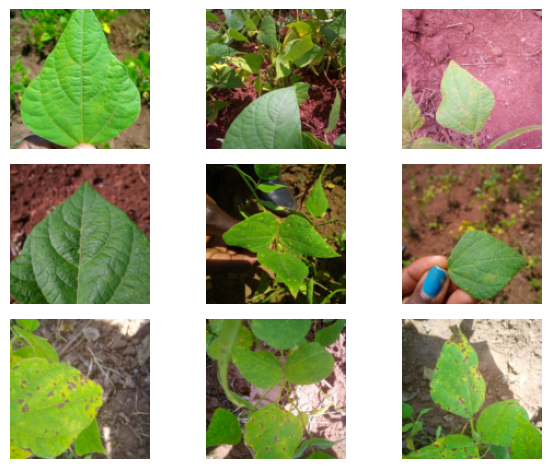

In [53]:
# Display a grid of sample images from the training dataset
n_rows = 3 # Number of rows in the grid
n_cols = 3 # Number of columns in the grid
f, axarr = plt.subplots(n_rows, n_cols) # Create a figure and a grid of subplots

# Iterate through the grid and display random images
for row in range(n_rows):
  for col in range(n_cols):
    # Get a random image from the training dataset
    image = train_dataset[np.random.randint(0, train_dataset.__len__())][0].cpu() # Get image and move to CPU for plotting

    # Display the image in the current subplot
    axarr[row, col].imshow((image*255.0).squeeze().permute(1, 2, 0)) # Display image, permute dimensions for matplotlib
    axarr[row, col].axis('off') # Turn off the axis

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show() # Display the plot

In [63]:
# Define hyperparameters for training
LR = 1e-3 # Learning rate
BATCH_SIZE = 4 # Batch size
EPOCHS = 15 # Number of training epochs

In [55]:
# Create data loaders for the training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True ) # DataLoader for training data
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True ) # DataLoader for validation data

In [56]:
# Load a pre-trained GoogLeNet model with default weights
googlenet_model = models.googlenet(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 152MB/s]


In [57]:
# Set all parameters of the GoogLeNet model to require gradients
for param in googlenet_model.parameters():
  param.requires_grad = True

In [58]:
# Access the fully connected layer of the GoogLeNet model
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [59]:
# Get the number of unique classes from the training dataframe
num_classes = len(train_df["category"].unique())
# Print the number of classes
num_classes

3

In [60]:
# Replace the last fully connected layer of the GoogLeNet model
# with a new linear layer with the number of output features equal to the number of classes
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
# Print the modified fully connected layer
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [61]:
# Move the GoogLeNet model to the selected device (GPU or CPU)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [65]:
# Define the loss function (Cross-Entropy Loss for classification)
loss_fun = nn.CrossEntropyLoss()
# Define the optimizer (Adam optimizer with the specified learning rate)
optimizer = Adam(googlenet_model.parameters(), lr = LR)

# Lists to store total loss and accuracy for plotting (though not plotted in the current code)
total_loss_train_plot = []
total_acc_train_plot = []

# Training loop
for epoch in range(EPOCHS):
  total_acc_train = 0 # Initialize training accuracy for the epoch
  total_loss_train = 0 # Initialize training loss for the epoch

  # Iterate through the training data loader
  for inputs, labels in train_loader:
    optimizer.zero_grad() # Zero the gradients
    outputs = googlenet_model(inputs) # Get model outputs (predictions)

    train_loss = loss_fun(outputs, labels) # Calculate the loss
    total_loss_train += train_loss.item() # Accumulate the loss

    train_loss.backward() # Backpropagate the loss

    # Calculate training accuracy for the current batch
    train_acc = (torch.argmax(outputs, axis =1) == labels).sum().item()
    total_acc_train += train_acc # Accumulate the correct predictions
    optimizer.step() # Update model parameters

  # Append epoch loss and accuracy to the lists (scaled loss for plotting)
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))

  # Print epoch statistics
  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss {round(total_loss_train/1000, 4)}, Train Accuracy {round(total_acc_train/train_dataset.__len__()*100, 4)}")

Epoch 1/15, Train Loss 0.2353, Train Accuracy 58.7041
Epoch 2/15, Train Loss 0.2162, Train Accuracy 63.5397
Epoch 3/15, Train Loss 0.1926, Train Accuracy 68.1818
Epoch 4/15, Train Loss 0.1836, Train Accuracy 72.147
Epoch 5/15, Train Loss 0.1848, Train Accuracy 69.0522
Epoch 6/15, Train Loss 0.173, Train Accuracy 74.2747
Epoch 7/15, Train Loss 0.1635, Train Accuracy 73.6944
Epoch 8/15, Train Loss 0.1463, Train Accuracy 77.853
Epoch 9/15, Train Loss 0.1403, Train Accuracy 78.3366
Epoch 10/15, Train Loss 0.1473, Train Accuracy 76.8859
Epoch 11/15, Train Loss 0.1297, Train Accuracy 80.8511
Epoch 12/15, Train Loss 0.1304, Train Accuracy 80.4642
Epoch 13/15, Train Loss 0.1295, Train Accuracy 82.7853
Epoch 14/15, Train Loss 0.119, Train Accuracy 82.7853
Epoch 15/15, Train Loss 0.1225, Train Accuracy 81.7215


In [66]:
# Evaluate the model on the validation set
with torch.no_grad(): # Disable gradient calculation for evaluation
  total_acc_test = 0 # Initialize validation accuracy counter

  for input, labels in val_loader: # Iterate through the validation data loader
    prediction = googlenet_model(input) # Get model predictions

    # Calculate the number of correctly predicted samples in the current batch
    acc = (torch.argmax(prediction, axis=1)== labels).sum().item()
    total_acc_test += acc # Accumulate the correct predictions

In [67]:
# Print the overall test accuracy calculated in the previous cell
print(round(total_acc_test/val_dataset.__len__()*100, 2))

74.44


Transfer Learning

In [69]:
# Load a pre-trained GoogLeNet model again for transfer learning
googlenet_model1 = models.googlenet(weights='DEFAULT')

# Freeze all parameters in the model (set requires_grad to False)
for param in googlenet_model1.parameters():
  param.requires_grad = False

# Replace the last fully connected layer with a new linear layer for the number of classes
googlenet_model1.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
# Unfreeze the parameters of the new fully connected layer so they can be trained
googlenet_model1.fc.requires_grad = True

In [70]:
# Define the loss function (Cross-Entropy Loss for classification) - same as before
loss_fun = nn.CrossEntropyLoss()
# Define the optimizer (Adam optimizer with the specified learning rate) - optimizer for the new model
optimizer = Adam(googlenet_model1.parameters(), lr = LR) # Optimize only the unfrozen parameters

# Lists to store total loss and accuracy for plotting (though not plotted in the current code) - reinitialized for the new model
total_loss_train_plot = []
total_acc_train_plot = []

# Training loop for the transfer learning model
for epoch in range(EPOCHS):
  total_acc_train = 0 # Initialize training accuracy for the epoch
  total_loss_train = 0 # Initialize training loss for the epoch

  # Iterate through the training data loader
  for inputs, labels in train_loader:
    optimizer.zero_grad() # Zero the gradients
    outputs = googlenet_model(inputs) # Get model outputs (predictions) - NOTE: This should be googlenet_model1

    train_loss = loss_fun(outputs, labels) # Calculate the loss
    total_loss_train += train_loss.item() # Accumulate the loss

    train_loss.backward() # Backpropagate the loss

    # Calculate training accuracy for the current batch
    train_acc = (torch.argmax(outputs, axis =1) == labels).sum().item()
    total_acc_train += train_acc # Accumulate the correct predictions
    optimizer.step() # Update model parameters

  # Append epoch loss and accuracy to the lists (scaled loss for plotting)
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))

  # Print epoch statistics
  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss {round(total_loss_train/1000, 4)}, Train Accuracy {round(total_acc_train/train_dataset.__len__()*100, 4)}")

Epoch 1/15, Train Loss 0.1194, Train Accuracy 83.1721
Epoch 2/15, Train Loss 0.1165, Train Accuracy 84.1393
Epoch 3/15, Train Loss 0.1143, Train Accuracy 85.0097
Epoch 4/15, Train Loss 0.12, Train Accuracy 83.2689
Epoch 5/15, Train Loss 0.1203, Train Accuracy 83.3656
Epoch 6/15, Train Loss 0.1186, Train Accuracy 83.6557
Epoch 7/15, Train Loss 0.1181, Train Accuracy 82.205
Epoch 8/15, Train Loss 0.1127, Train Accuracy 82.882
Epoch 9/15, Train Loss 0.1257, Train Accuracy 83.0754
Epoch 10/15, Train Loss 0.1143, Train Accuracy 85.0097
Epoch 11/15, Train Loss 0.1159, Train Accuracy 83.9458
Epoch 12/15, Train Loss 0.1183, Train Accuracy 81.9149
Epoch 13/15, Train Loss 0.1105, Train Accuracy 84.4294
Epoch 14/15, Train Loss 0.1121, Train Accuracy 83.559
Epoch 15/15, Train Loss 0.1278, Train Accuracy 81.9149


In [71]:
# Evaluate the transfer learning model on the validation set
with torch.no_grad(): # Disable gradient calculation for evaluation
  total_acc_test = 0 # Initialize validation accuracy counter

  for input, labels in val_loader: # Iterate through the validation data loader
    prediction = googlenet_model(input) # Get model predictions - NOTE: This should be googlenet_model1

    # Calculate the number of correctly predicted samples in the current batch
    acc = (torch.argmax(prediction, axis=1)== labels).sum().item()
    total_acc_test += acc # Accumulate the correct predictions

# Print the overall test accuracy
print(round(total_acc_test/val_dataset.__len__()*100, 2))

75.19
